# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: *Ian McLoughlin (https://github.com/ianmcloughlin)*

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Loading Data](#loading_data)
* [](#)
* [](#)
* [](#)
* [](#)

<br>

### Overview <a name="overview"></a>
___

<br>

### General Setup <a name="setup"></a>
___

In [1]:
# Neural networks.
import tensorflow.keras as kr

# Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Machine learning - k-NN.
from sklearn.neighbors import KNeighborsRegressor as neigh


# Numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
# Another package for plotting.
import seaborn as sns

%matplotlib inline

In [2]:
# Theme for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5, )

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Loading Data <a name="loading_data"></a>
___

> [1] [Adjusting Size of Seaborn Plot](https://stackoverflow.com/questions/51502927/adjusting-size-of-seaborn-plot)

In [3]:
# Load the iris data set from a URL.
df = pd.read_csv("powerproduction.csv")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [4]:
# Check for empty values.
df.isnull().values.any()

False

In [5]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


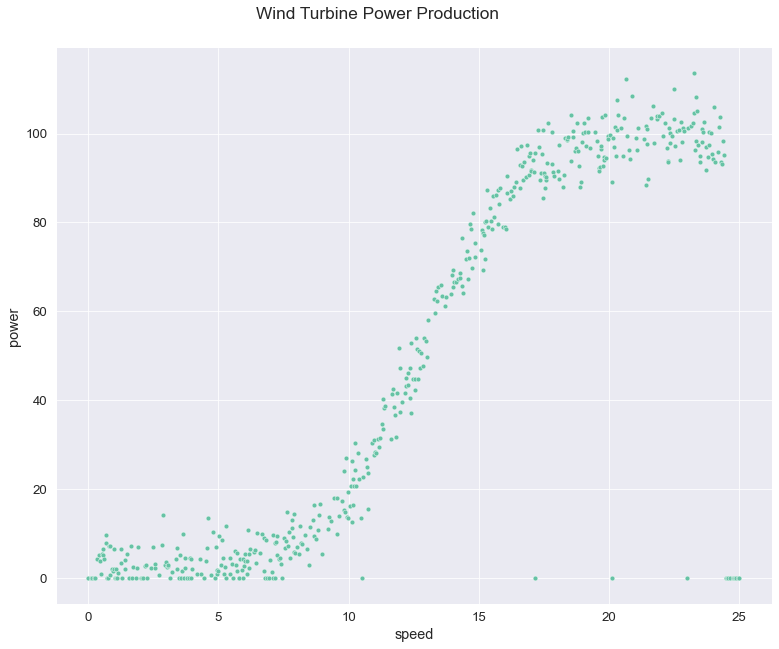

In [6]:
# Plot data.
sns.relplot(data=df, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production", y=1.02)

# Show the plot.
plt.show()

The above plot shows that the data follows a non-linear model. The relationship between Power and Speed predominantly take "S"-shape (sigmoid curve). The power rises dramatically with speed over about 8 m/s and slows when the speed reaches about 17 m/s.

Additionally, we can see some outliners where the speed is above 10 m/s, however, the power is still 0.

<br>

###  Data Pre-processing.
___

The first step is to remove those outliners from our data set. [2]

> [2] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [7]:
df_new = df.drop(df[(df.power == 0) & (df.speed > 5)].index)
df_new

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


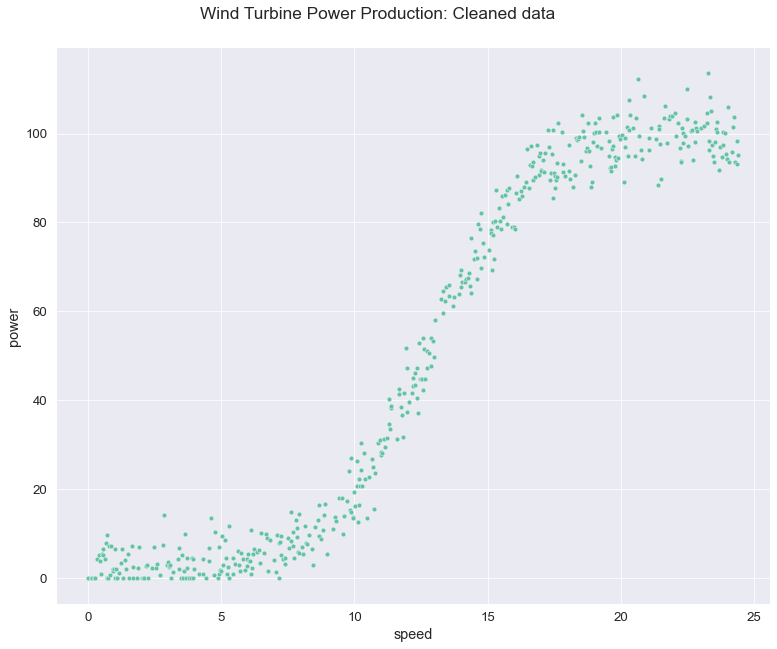

In [8]:
# Plot data.
sns.relplot(data=df_new, x="speed", y="power")

# Change plot size.
fig = plt.gcf()
fig.set_size_inches(12, 9)
fig.suptitle("Wind Turbine Power Production: Cleaned data", y=1.02)

# Show the plot.
plt.show()

In [9]:
# Separate speed from power.
speed = df_new.iloc[:, 0]
power = df_new.iloc[:, 1]

# Convert them into a numpy array.
X = np.array(speed.values).reshape(-1,1)
y = np.array(power.values).reshape(-1,1)
#y_knn = LabelEncoder().fit_transform(y.astype('str'))

Finally, since we have Polynomial regression we can apply PolynomialFeatures.

>[3] [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py)

In [10]:
# Find the best degree.
for degree in range(1,6):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    print(f'{degree}: {model.score(X,y)}')

1: 0.903329459488843
2: 0.9051962906190765
3: 0.9785336368530014
4: 0.9798972502580137
5: 0.988364899815888


The results show that the 5 degrees give the best results. Let's first plot it and then apply it to the speed data.

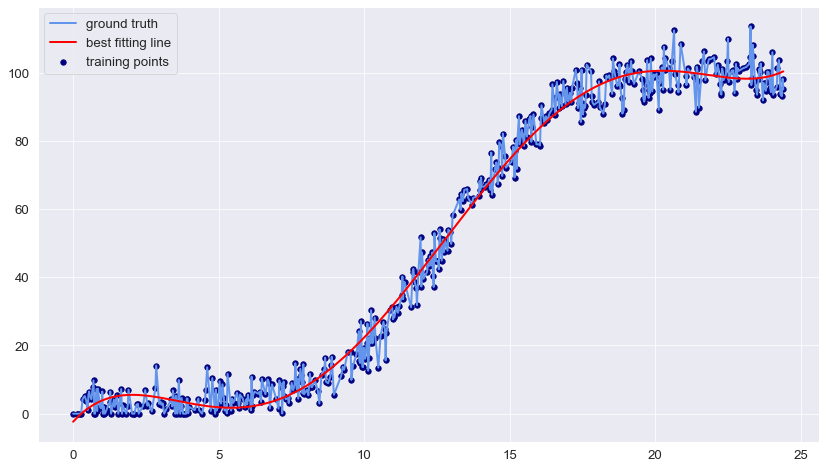

In [11]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot training points and line connecting them.
ax.plot(X, y, color='cornflowerblue', linewidth=2, label="ground truth")
ax.scatter(X, y, color='navy', s=30, marker='o', label="training points")

# Create a pipeline
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X, y)
y_pred = model.predict(X)

# Plot predictions.
ax.plot(X, y_pred, color="red", linewidth=2, label="best fitting line")

# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

In [12]:
# Split data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = tts(X, y, test_size=0.3, random_state=1)

<br>

### Pipeline Model
___

NameError: name 'ploy' is not defined

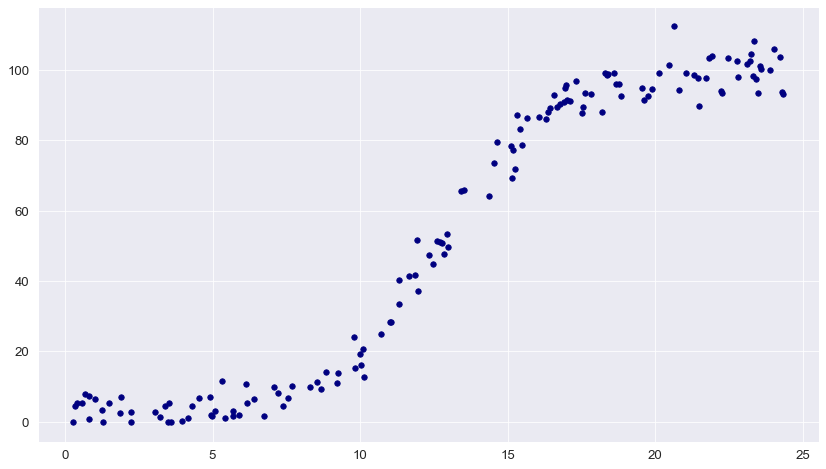

In [13]:
# Create a figure and axis
fig, ax = plt.subplots()

# Actual test data.
ax.scatter(speed_test, power_test, color='navy', s=30, marker='o', label="Actual")

# Create a pipeline
poly = make_pipeline(PolynomialFeatures(5), Ridge())
ploy.fit(speed_train, power_train)
y_pred = poly.predict(speed_test)

# Plot predictions.
ax.scatter(speed_test, y_pred, color="yellow", linewidth=2, label="Predicted")

# Show legend.
plt.legend(loc='upper left')

# Show the plot.
plt.show()

Next we need to split the data set into training and testing data. 

In [ ]:
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X)

In [ ]:
# Split data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = tts(X_expanded, y, test_size=0.3, random_state=1)

In [ ]:
# Check the shape of tested data.
print(f"Trained data: {speed_train.shape}, {power_train.shape}")
print(f"Tested data: {speed_test.shape}, {power_test.shape}")

<br>

###  k-Nearest Neighbors.
___


In [ ]:
# Find the highest accuracy and lowest error.
score = []
error_rate = []

# Find optimal k-value from 1-39
for k in range(1, 40):

    # Create an instance of the k-NN and fit data.
    knn = neigh(k)
    knn.fit(speed_train,power_train)
    pred_y = knn.predict(speed_test)
    score.append(knn.score(speed_test,power_test))

    # Check when predicted output doesn't match real output
    error_rate.append(np.mean(pred_y != power_test))
    

# Print a k-values with minimum error (+1 as indexing starts at 0 position)
print("Minimum error:",min(error_rate),"at K =",1+error_rate.index(min(error_rate)))
# Print a k-values with minimum error (+1 as indexing starts at 0 position)
print("Maximum accuracy score:",max(score),"at K =",1+score.index(max(score)))

<br>

### Neural Networks.
___


In [ ]:
# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile("adam", loss='mse')

In [ ]:
# Train the neural network on our training data.
model.fit(speed_train, power_train, epochs=400)

In [ ]:

# Now let's see.
plt.scatter(speed_train, power_train, label='actual')
plt.scatter(speed_test, model.predict(speed_test), label='prediction', c="r")
plt.legend()
plt.show()